# Benchmark de modelos preentrenados para clasificación

En este trabajo comparamos cuatro modelos preentrenados populares: **ResNet18** (nuestro baseline), **EfficientNet_B0**, **MobileNet_V3_Large** y **ConvNeXt_Tiny**.

En el caso del **ResNet18**, descongelamos las últimas **tres capas** del backbone para que puedan ajustarse durante el entrenamiento. Para los otros tres modelos, solo descongelamos la **última capa**.

Luego, reemplazamos esa capa descongelada por una identidad (`nn.Identity()`), lo que permite conectar un clasificador personalizado compuesto por capas lineales, activaciones y dropout que realiza la clasificación final.

En resumen, el flujo es:

**backbone (capas descongeladas entrenables) → capa identidad → clasificador personalizado**.

Este método aprovecha el aprendizaje transferido del backbone mientras ajusta la salida para nuestras clases específicas.

Para la optimización, consideramos tres valores diferentes de learning rate como principal hiperparámetro a ajustar, dado que los recursos y tiempo disponibles limitan la exploración de otros ajustes.

----------------

La elección de estas arquitecturas se basa en el trabajo *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks* ([Paper en arXiv](https://arxiv.org/pdf/1905.11946)), así como en el análisis presentado en este [artículo](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/). En particular, se seleccionó el modelo **EfficientNet_B0** (utilizado como baseline en dicho estudio) por mostrar un desempeño superior al **ResNet32**, como se ilustra en la siguiente figura (Figura 1 del paper).

Además, se incorporaron los modelos **MobileNet_V3_Large** y **ConvNeXt_Tiny** para ampliar la comparación. MobileNet_V3 también presenta buen desempeño usando *compound scaling* (método desarrollado para balancear profundidad, ancho y resolución de la red de manera eficiente), mientras que ConvNeXt_Tiny es una arquitectura moderna, eficiente y competitiva que no aparece en el estudio original.

Dado el método desarrollado en el estudio de EfficientNet y basado en la mejora de performance lograda mediante *compound scaling* (ver el paper para más detalles), en etapas posteriores se planea extender el análisis a modelos **EfficientNet** más avanzados, como los **B1**, **B2**, y sucesivos.


<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png" alt="Descripción" height="400">

In [7]:
# Import shutil first to prevent the kernel from crashing
import shutil

# Recommended by PyTorch Lightning to leverage Tensor Cores (due to my GPU architecture)
import torch
torch.set_float32_matmul_precision('medium')

# Borrar checkpoints anteriores
# shutil.rmtree("checkpoints", ignore_errors=True)

# Borrar logs anteriores
#shutil.rmtree("lightning_logs", ignore_errors=True)

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
import os

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        base_model = base_model_fn(weights=weights)
        for name, param in base_model.named_parameters():
            if freeze_layer_name not in name:
                param.requires_grad = False
        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            if isinstance(base_model.classifier, nn.Sequential):
                base_model.classifier = nn.Identity()
                in_features = get_in_features(base_model)
            else:
                base_model.classifier = nn.Identity()
                in_features = get_in_features(base_model)
        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [5]:
os.makedirs("checkpoints", exist_ok=True)
results = {}
history = {}
learning_rates = [1e-4, 3e-5, 1e-5]

for lr in learning_rates:
    fn, w, freeze_name = models.resnet18, models.ResNet18_Weights.DEFAULT, "layer2"
    name = fn.__name__

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
    logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
    model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
    trainer = Trainer(
        max_epochs=40,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=logger
    )
    trainer.fit(model, train_loader, val_loader)

    checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
    trainer.save_checkpoint(checkpoint_path, weights_only=True)

    metrics_df = logger.experiment.metrics
    history[f"{name}_lr{lr}"] = metrics_df

    model.eval()
    all_preds, all_labels = [], []
    for x, y in test_loader:
        x = x.to(model.device)
        with torch.no_grad():
            preds = model(x).argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y)
    results[f"{name}_lr{lr}"] = {
        "preds": torch.cat(all_preds),
        "labels": torch.cat(all_labels)
    }

Entrenando resnet18 con lr=0.0001: congelando todo menos layer2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
657 K     Trainable params
10.7 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Sanity Checking:   0%|                                                                           | 0/2 [00:00<?, ?it/s]

C:\Users\Alejandro\anaconda3\envs\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\Alejandro\anaconda3\envs\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:06<00:00, 16.60it/s, v_num=7, train_loss=0.690]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:05<00:00, 18.04it/s, v_num=7, train_loss=0.269, val_loss=0.942, val_acc=0.609]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:05<00:00, 18.21it/s, v_num=7, train_loss=1.020, val_loss=0.914, val_acc=0.583]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:05<00:00, 18.40it/s, v_num=7, train_loss=0.923, val_loss=0.924, val_acc=0.554]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:07<00:00, 14.27it/s, v_num=7, train_loss=0.105, val_loss=1.410, val_acc=0.704]
Entrenando resnet18 con lr=3e-05: congelando todo menos layer2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
657 K     Trainable params
10.7 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:05<00:00, 18.93it/s, v_num=0, train_loss=0.730]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:05<00:00, 18.80it/s, v_num=0, train_loss=0.786, val_loss=1.020, val_acc=0.514]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:05<00:00, 18.84it/s, v_num=0, train_loss=0.911, val_loss=0.938, val_acc=0.537]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:05<00:00, 18.94it/s, v_num=0, train_loss=1.290, val_loss=0.881, val_acc=0.586]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:07<00:00, 14.26it/s, v_num=0, train_loss=0.371, val_loss=0.852, val_acc=0.702]
Entrenando resnet18 con lr=1e-05: congelando todo menos layer2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
657 K     Trainable params
10.7 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:05<00:00, 18.40it/s, v_num=0, train_loss=1.140]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:05<00:00, 18.64it/s, v_num=0, train_loss=1.010, val_loss=1.050, val_acc=0.489]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:05<00:00, 18.87it/s, v_num=0, train_loss=1.050, val_loss=0.994, val_acc=0.550]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:05<00:00, 18.73it/s, v_num=0, train_loss=0.973, val_loss=0.949, val_acc=0.528]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:08<00:00, 12.78it/s, v_num=0, train_loss=0.903, val_loss=0.869, val_acc=0.649]


In [6]:
learning_rates = [1e-4, 3e-5, 1e-5]

for lr in learning_rates:
    fn, w, freeze_name = models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.2"
    name = fn.__name__

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
    logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
    model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
    trainer = Trainer(
        max_epochs=40,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=logger
    )
    trainer.fit(model, train_loader, val_loader)

    checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
    trainer.save_checkpoint(checkpoint_path, weights_only=True)

    metrics_df = logger.experiment.metrics
    history[f"{name}_lr{lr}"] = metrics_df

    model.eval()
    all_preds, all_labels = [], []
    for x, y in test_loader:
        x = x.to(model.device)
        with torch.no_grad():
            preds = model(x).argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y)
    results[f"{name}_lr{lr}"] = {
        "preds": torch.cat(all_preds),
        "labels": torch.cat(all_labels)
    }

Entrenando efficientnet_b0 con lr=0.0001: congelando todo menos features.2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
345 K     Trainable params
4.0 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:12<00:00,  8.43it/s, v_num=4, train_loss=0.689]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:12<00:00,  8.72it/s, v_num=4, train_loss=0.903, val_loss=0.960, val_acc=0.546]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:11<00:00,  8.88it/s, v_num=4, train_loss=0.401, val_loss=0.910, val_acc=0.602]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:11<00:00,  9.14it/s, v_num=4, train_loss=1.730, val_loss=0.890, val_acc=0.599]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:14<00:00,  7.49it/s, v_num=4, train_loss=0.479, val_loss=0.720, val_acc=0.721]
Entrenando efficientnet_b0 con lr=3e-05: congelando todo menos features.2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
345 K     Trainable params
4.0 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:11<00:00,  9.05it/s, v_num=0, train_loss=0.887]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:11<00:00,  9.05it/s, v_num=0, train_loss=0.835, val_loss=1.020, val_acc=0.569]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:11<00:00,  8.97it/s, v_num=0, train_loss=0.638, val_loss=0.980, val_acc=0.571]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:11<00:00,  9.05it/s, v_num=0, train_loss=0.729, val_loss=0.952, val_acc=0.579]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:14<00:00,  7.48it/s, v_num=0, train_loss=0.293, val_loss=0.762, val_acc=0.681]
Entrenando efficientnet_b0 con lr=1e-05: congelando todo menos features.2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
345 K     Trainable params
4.0 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:11<00:00,  8.96it/s, v_num=0, train_loss=1.130]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:12<00:00,  8.73it/s, v_num=0, train_loss=1.250, val_loss=1.080, val_acc=0.487]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:12<00:00,  8.74it/s, v_num=0, train_loss=1.020, val_loss=1.050, val_acc=0.536]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:11<00:00,  9.02it/s, v_num=0, train_loss=1.020, val_loss=1.030, val_acc=0.542]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:14<00:00,  7.47it/s, v_num=0, train_loss=0.187, val_loss=0.855, val_acc=0.631]


In [7]:
learning_rates = [1e-4, 3e-5, 1e-5]

for lr in learning_rates:
    fn, w, freeze_name = models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.3"
    name = fn.__name__

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
    logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
    model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
    trainer = Trainer(
        max_epochs=40,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=logger
    )
    trainer.fit(model, train_loader, val_loader)

    checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
    trainer.save_checkpoint(checkpoint_path, weights_only=True)

    metrics_df = logger.experiment.metrics
    history[f"{name}_lr{lr}"] = metrics_df

    model.eval()
    all_preds, all_labels = [], []
    for x, y in test_loader:
        x = x.to(model.device)
        with torch.no_grad():
            preds = model(x).argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y)
    results[f"{name}_lr{lr}"] = {
        "preds": torch.cat(all_preds),
        "labels": torch.cat(all_labels)
    }

Entrenando mobilenet_v3_large con lr=0.0001: congelando todo menos features.3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
251 K     Trainable params
3.0 M     Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:08<00:00, 12.58it/s, v_num=1, train_loss=0.991]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:07<00:00, 13.16it/s, v_num=1, train_loss=0.705, val_loss=0.996, val_acc=0.538]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:07<00:00, 13.32it/s, v_num=1, train_loss=1.450, val_loss=0.939, val_acc=0.594]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:07<00:00, 13.26it/s, v_num=1, train_loss=0.378, val_loss=0.919, val_acc=0.562]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:10<00:00, 10.29it/s, v_num=1, train_loss=0.695, val_loss=0.728, val_acc=0.696]
Entrenando mobilenet_v3_large con lr=3e-05: congelando todo menos features.3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
251 K     Trainable params
3.0 M     Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:07<00:00, 13.44it/s, v_num=0, train_loss=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:07<00:00, 13.46it/s, v_num=0, train_loss=1.360, val_loss=1.060, val_acc=0.469]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:07<00:00, 13.41it/s, v_num=0, train_loss=1.120, val_loss=1.020, val_acc=0.520]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:07<00:00, 13.17it/s, v_num=0, train_loss=0.831, val_loss=0.984, val_acc=0.538]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:09<00:00, 10.54it/s, v_num=0, train_loss=1.420, val_loss=0.809, val_acc=0.653]
Entrenando mobilenet_v3_large con lr=1e-05: congelando todo menos features.3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
251 K     Trainable params
3.0 M     Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:07<00:00, 13.42it/s, v_num=0, train_loss=1.160]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:07<00:00, 13.28it/s, v_num=0, train_loss=1.150, val_loss=1.090, val_acc=0.412]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:07<00:00, 13.18it/s, v_num=0, train_loss=1.120, val_loss=1.070, val_acc=0.442]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:07<00:00, 13.23it/s, v_num=0, train_loss=0.866, val_loss=1.060, val_acc=0.478]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:09<00:00, 10.96it/s, v_num=0, train_loss=0.300, val_loss=0.890, val_acc=0.605]


In [8]:
# Assuming train_loader, val_loader, test_loader are already defined
# and the LitClassifier class is available.
# results and history dictionaries should be initialized once.

learning_rates = [1e-4, 3e-5, 1e-5]

for lr in learning_rates:
    fn, w, freeze_name = models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.2"
    name = fn.__name__

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
    logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
    model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
    trainer = Trainer(
        max_epochs=40,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=logger
    )
    trainer.fit(model, train_loader, val_loader)

    checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
    trainer.save_checkpoint(checkpoint_path, weights_only=True)

    metrics_df = logger.experiment.metrics
    history[f"{name}_lr{lr}"] = metrics_df

    model.eval()
    all_preds, all_labels = [], []
    for x, y in test_loader:
        x = x.to(model.device)
        with torch.no_grad():
            preds = model(x).argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y)
    results[f"{name}_lr{lr}"] = {
        "preds": torch.cat(all_preds),
        "labels": torch.cat(all_labels)
    }

Entrenando convnext_tiny con lr=0.0001: congelando todo menos features.2
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\Alejandro/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth


100%|███████████████████████████████████████████████████████████████████████████████| 109M/109M [00:03<00:00, 33.8MB/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
271 K     Trainable params
27.7 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:17<00:00,  6.00it/s, v_num=0, train_loss=0.930]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:13<00:00,  8.02it/s, v_num=0, train_loss=1.080, val_loss=0.999, val_acc=0.552]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:13<00:00,  8.04it/s, v_num=0, train_loss=0.684, val_loss=0.942, val_acc=0.551]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:13<00:00,  8.00it/s, v_num=0, train_loss=0.661, val_loss=0.897, val_acc=0.608]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|███████████| 105/105 [00:17<00:00,  6.04it/s, v_num=0, train_loss=0.0662, val_loss=1.570, val_acc=0.652]
Entrenando convnext_tiny con lr=3e-05: congelando todo menos features.2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
271 K     Trainable params
27.7 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:13<00:00,  7.86it/s, v_num=0, train_loss=1.090]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:13<00:00,  7.76it/s, v_num=0, train_loss=1.070, val_loss=1.070, val_acc=0.551]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:13<00:00,  7.73it/s, v_num=0, train_loss=1.050, val_loss=1.030, val_acc=0.571]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:13<00:00,  7.74it/s, v_num=0, train_loss=0.796, val_loss=0.996, val_acc=0.574]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:17<00:00,  6.03it/s, v_num=0, train_loss=0.573, val_loss=0.862, val_acc=0.631]
Entrenando convnext_tiny con lr=1e-05: congelando todo menos features.2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
271 K     Trainable params
27.7 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████| 105/105 [00:13<00:00,  7.87it/s, v_num=0, train_loss=1.040]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████| 105/105 [00:13<00:00,  7.79it/s, v_num=0, train_loss=1.100, val_loss=1.090, val_acc=0.350]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████| 105/105 [00:13<00:00,  7.74it/s, v_num=0, train_loss=1.020, val_loss=1.080, val_acc=0.469]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 105/105 [00:13<00:00,  7.71it/s, v_num=0, train_loss=1.030, val_loss=1.070, val_acc=0.519]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████| 105/105 [00

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████| 105/105 [00:17<00:00,  6.08it/s, v_num=0, train_loss=1.530, val_loss=0.896, val_acc=0.611]


In [8]:
import pandas as pd
import os

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

In [13]:
import torch
from pytorch_lightning import Trainer
from torchvision import models

# Your LitClassifier class definition should be available in this environment.
# Assumes test_loader is already defined.

# This is a sample list of the trained models. Adjust if necessary.
model_defs = [
    (models.resnet18, models.ResNet18_Weights.DEFAULT, "layer2"),
    (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.2"),
    (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.3"),
    (models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.2"),
]
learning_rates = [1e-4, 3e-5, 1e-5]

results = {}

for lr in learning_rates:
    for fn, w, freeze_name in model_defs:
        name = fn.__name__
        key = f"{name}_lr{lr}"
        checkpoint_path = f"checkpoints/{key}_final.ckpt"

        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint not found for {key}. Skipping.")
            continue

        # Load the model from the checkpoint.
        model = LitClassifier.load_from_checkpoint(
            checkpoint_path,
            base_model_fn=fn,
            weights=w,
            freeze_layer_name=freeze_name,
            num_classes=3,
            lr=lr
        )
        model.eval()

        all_preds, all_labels = [], []
        for x, y in test_loader:
            x = x.to(model.device)
            with torch.no_grad():
                preds = model(x).argmax(1)
                all_preds.append(preds.cpu())
                all_labels.append(y)

        results[key] = {
            "preds": torch.cat(all_preds),
            "labels": torch.cat(all_labels)
        }
        print(f"Predictions re-generated for {key}")

# Now you can use the 'results' variable for your plotting.
# Optionally, save it to disk.
torch.save(results, "results.pt")

Predictions re-generated for resnet18_lr0.0001
Predictions re-generated for efficientnet_b0_lr0.0001
Predictions re-generated for mobilenet_v3_large_lr0.0001
Predictions re-generated for convnext_tiny_lr0.0001
Predictions re-generated for resnet18_lr3e-05
Predictions re-generated for efficientnet_b0_lr3e-05
Predictions re-generated for mobilenet_v3_large_lr3e-05
Predictions re-generated for convnext_tiny_lr3e-05
Predictions re-generated for resnet18_lr1e-05
Predictions re-generated for efficientnet_b0_lr1e-05
Predictions re-generated for mobilenet_v3_large_lr1e-05
Predictions re-generated for convnext_tiny_lr1e-05


Comparo loss y accuracy a lo largo del entrenamiento (por época), siempre evaluando con el conjunto de validación para asegurar que el modelo generalice bien.

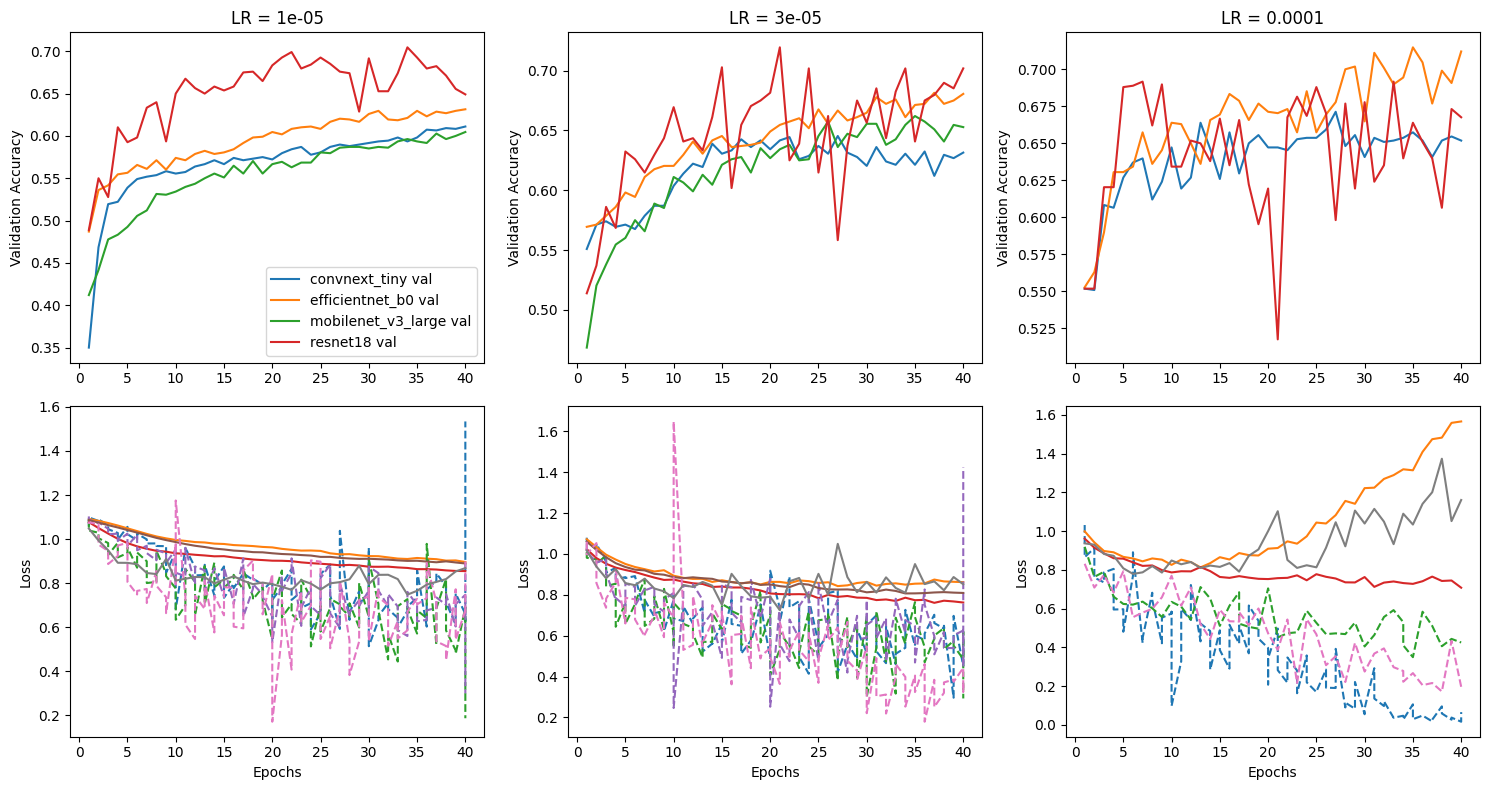

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

lrs = sorted({float(k.split("_lr")[1]) for k in history.keys()})
modelos = sorted({k.split("_lr")[0] for k in history.keys()})

fig, axes = plt.subplots(2, len(lrs), figsize=(5*len(lrs), 8), sharex=False)

for col, lr in enumerate(lrs):
    for modelo in modelos:
        key = f"{modelo}_lr{lr}"
        if key not in history:
            continue

        df = history[key]

        # Filtrar rows con train_loss (entrenamiento)
        train_loss_df = df.dropna(subset=['train_loss'])
        epochs_train = train_loss_df['epoch'] + 1  # +1 para que empiece en 1
        train_loss = train_loss_df['train_loss']

        # Filtrar rows con val_loss y val_acc (validación)
        val_df = df.dropna(subset=['val_loss', 'val_acc'])
        epochs_val = val_df['epoch'] + 1
        val_loss = val_df['val_loss']
        val_acc = val_df['val_acc']

        # Graficar accuracy validación
        axes[0, col].plot(epochs_val, val_acc, label=f"{modelo} val", linestyle='-')

        # Graficar loss entrenamiento y validación
        axes[1, col].plot(epochs_train, train_loss, label=f"{modelo} train", linestyle='--')
        axes[1, col].plot(epochs_val, val_loss, label=f"{modelo} val", linestyle='-')

    axes[0, col].set_title(f"LR = {lr}")
    axes[0, col].set_ylabel("Validation Accuracy")
    axes[1, col].set_ylabel("Loss")
    axes[1, col].set_xlabel("Epochs")

axes[0, 0].legend(loc='best')

plt.tight_layout()
plt.show()


**Análisis general por learning rate:**

LR = 1e-5: Este learning rate produce una curva de aprendizaje estable para la mayoría de los modelos. ResNet18 logra el Accuracy de validación más alto, manteniéndose por encima del 0.65. EfficientNet_B0 y ConvNeXt_Tiny también tienen un rendimiento estable, pero con valores más bajos. El Loss de entrenamiento y validación converge de manera consistente.

LR = 3e-5: Este learning rate intermedio muestra un comportamiento más volátil. Aunque algunos modelos, como EfficientNet_B0 y ResNet18, alcanzan picos de Accuracy similar al del learning rate de 1e-5, sus curvas son menos estables. El Loss de entrenamiento para ResNet18 (línea roja discontinua) es particularmente inestable.

LR = 1e-4: Este learning rate es demasiado alto para varios modelos, resultando en un entrenamiento inestable. La curva de Accuracy de validación de ResNet18 y ConvNeXt_Tiny muestra grandes fluctuaciones. Sin embargo, EfficientNet_B0 es el único modelo que parece beneficiarse de este learning rate, mostrando una tendencia a la mejora continua y alcanzando un valor de Accuracy de validación muy alto al final del entrenamiento.

**Conclusiones por modelo:**

ResNet18: Este modelo es el mejor en el learning rate de 1e-5, mostrando el Accuracy más alto y una curva estable. Es muy sensible a la elección del learning rate, y su rendimiento se degrada significativamente con valores más altos.

EfficientNet_B0: Este modelo es el más robusto ante un learning rate alto. A diferencia de los otros modelos, su rendimiento parece mejorar con el learning rate de 1e-4, indicando que aún podría beneficiarse de un entrenamiento más largo o de un ajuste fino con este valor.

MobileNet_V3_Large: El rendimiento de este modelo es relativamente consistente en todos los learning rates, pero se mantiene por debajo de ResNet18 y EfficientNet_B0.

ConvNeXt_Tiny: Este modelo tiene un comportamiento estable con learning rates bajos, pero su rendimiento es similar al de MobileNet_V3_Large. Con el learning rate de 1e-4, su Accuracy de validación es el más bajo y su curva de entrenamiento es muy inestable.

## Comparación de modelos con matrices de confusión

A continuación se muestran las matrices de **confusión** para los cuatro modelos, tanto en forma **nominal** como **normalizada**. Se considera el mayor **learning rate** utilizado, ya que es el que ofrece mejores resultados en términos generales, tal como se mostrará al comparar **recall**, **F1** y un **puntaje personalizado**.

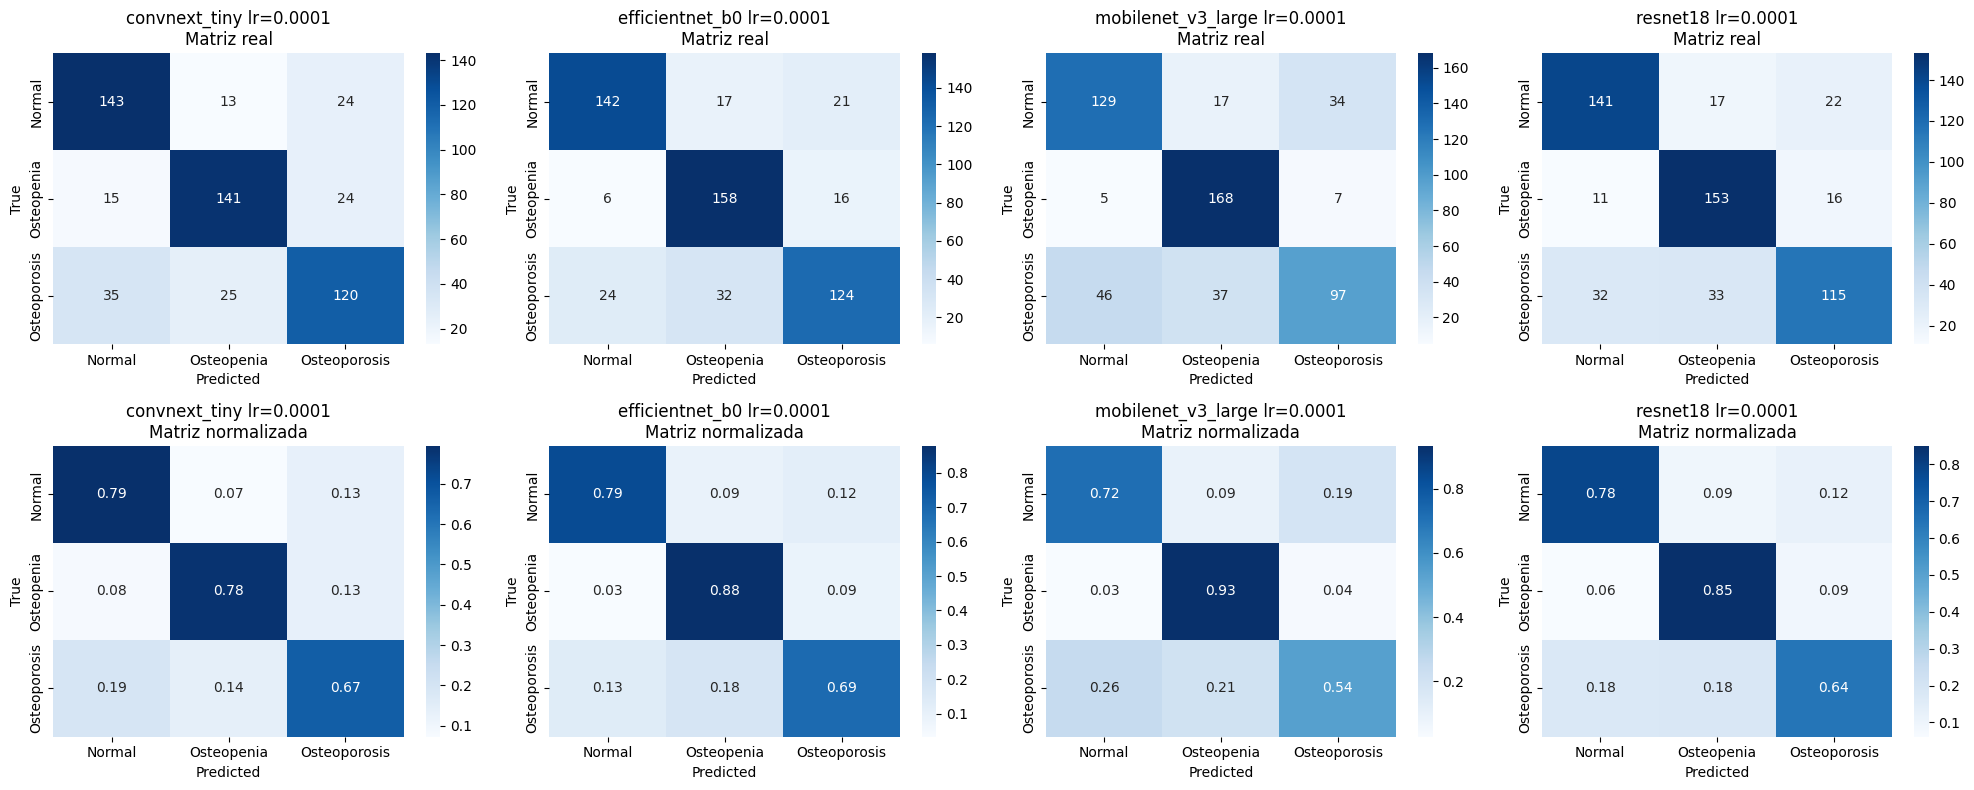

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

lr_target = 1e-4
model_names = sorted({k.split("_lr")[0] for k in results.keys()})

fig, axes = plt.subplots(2, len(model_names), figsize=(5 * len(model_names), 8))

for i, modelo in enumerate(model_names):
    key = f"{modelo}_lr{lr_target}"
    if key not in results:
        print(f"No hay resultados para {key}")
        continue

    y_true = results[key]["labels"].numpy()
    y_pred = results[key]["preds"].numpy()

    # Matriz real
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[0, i].set_title(f"{modelo} lr={lr_target}\nMatriz real")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("True")

    # Matriz normalizada por fila
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[1, i].set_title(f"{modelo} lr={lr_target}\nMatriz normalizada")
    axes[1, i].set_xlabel("Predicted")
    axes[1, i].set_ylabel("True")

plt.tight_layout()
plt.show()


En general, todos los modelos tienen un rendimiento similar en esta configuración. La mayoría de ellos muestran una buena capacidad para clasificar la categoría "Normal". Sin embargo, todos tienen dificultades para distinguir entre "Osteopenia" y "Osteoporosis".

**Rendimiento por modelo**
ConvNeXt_Tiny: Muestra un rendimiento decente. Es muy bueno para identificar "Normal" (79% de acierto). Sin embargo, lucha con "Osteopenia", donde solo acierta el 13%, y confunde el 14% de los casos de "Osteoporosis" con "Osteopenia".

EfficientNet_B0: Este modelo es el mejor clasificador para la categoría "Normal", con un 88% de acierto, pero falla notablemente al clasificar "Osteopenia" (solo 3% de acierto), confundiendo la mayoría de los casos (88%) con "Normal".

MobileNet_V3_Large: Es el mejor para clasificar "Osteoporosis", con un 54% de acierto, y también es bueno para "Osteopenia" (93% de los casos de "Osteopenia" fueron clasificados como tal, pero con un gran número de falsos positivos).

ResNet18: Muestra un desempeño equilibrado, con una buena precisión para "Normal" (78%) y un rendimiento aceptable en las otras dos categorías.

**Puntos debiles comunes**
Confusión entre "Normal" y "Osteopenia": Todos los modelos confunden una cantidad significativa de casos de "Osteopenia" con "Normal" o viceversa, lo que indica que las diferencias entre estas dos categorías son sutiles.

Confusión entre "Osteopenia" y "Osteoporosis": Los modelos tienen problemas para separar estas dos categorías. A menudo confunden los casos de "Osteoporosis" con "Osteopenia". Esto sugiere que las características visuales de estas dos condiciones podrían ser muy similares para los modelos.

## Métricas adicionales

- **Recall enfermo vs sano:** mide qué tan bien el modelo detecta a los pacientes enfermos (osteopenia u osteoporosis) sin confundirlos con sanos. No distingue entre tipos de enfermedad, solo sano vs enfermo.

- **F1 entre enfermedades:** evalúa el equilibrio entre precisión y recall al clasificar las distintas enfermedades, solo considerando pacientes enfermos. Esta métrica distingue entre osteopenia y osteoporosis.

- **Puntaje diagnóstico:** combinación ponderada del recall general y el F1 específico para enfermedades, para evaluar globalmente el desempeño clínico.


In [15]:
from sklearn.metrics import recall_score, f1_score

# Defino las métricas

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    # Convertir a binario: 0 = Normal, 1 = Enfermo (Osteopenia u Osteoporosis)
    y_true_bin = [0 if x == 0 else 1 for x in y_true]
    y_pred_bin = [0 if x == 0 else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    # Filtro solo los casos enfermos
    y_true_sub = [x for x in y_true if x != 0]
    y_pred_sub = [p for x, p in zip(y_true, y_pred) if x != 0]
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    # Combino recall y f1 con pesos alpha y beta
    return alpha * recall + beta * f1_enf

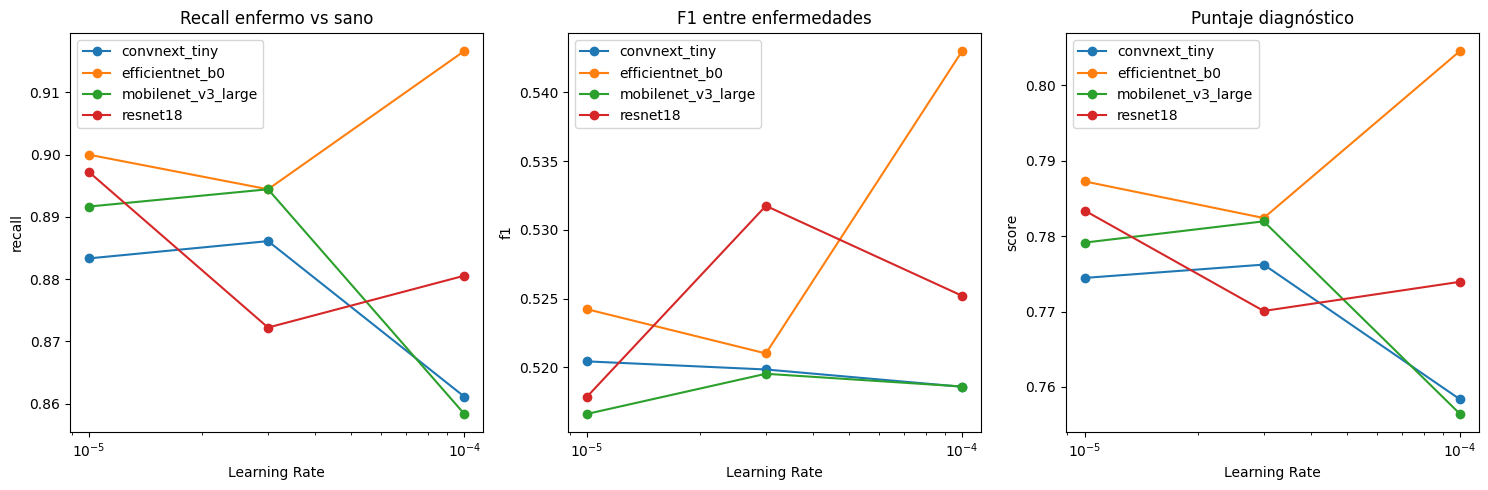

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Guardar métricas en lista
data = []
for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    lr = float(lr_str)
    
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    
    data.append({
        "modelo": model_name,
        "lr": lr,
        "recall": recall,
        "f1": f1,
        "score": score
    })

df = pd.DataFrame(data)
df = df.sort_values(by=["lr", "modelo"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

metricas = ["recall", "f1", "score"]
titulos = ["Recall enfermo vs sano", "F1 entre enfermedades", "Puntaje diagnóstico"]

for ax, metrica, titulo in zip(axes, metricas, titulos):
    for modelo, subdf in df.groupby("modelo"):
        ax.plot(subdf["lr"], subdf[metrica], marker="o", label=modelo)
    ax.set_title(titulo)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(metrica)
    ax.set_xscale("log")  
    ax.legend()

plt.tight_layout()
plt.show()


Basado en las tres métricas mostradas (Recall, F1 y Puntaje diagnóstico), el mejor modelo parece ser EfficientNet_B0. Este modelo obtiene consistentemente los valores más altos en las tres métricas, especialmente con un learning rate de 1e-4, donde su rendimiento se dispara.

Recall enfermo vs sano: EfficientNet_B0 tiene el recall más alto en todos los learning rates, alcanzando casi 0.92 con el learning rate de 1e-4. Los otros modelos se mantienen por debajo de 0.90.

F1 entre enfermedades: Similar a la métrica anterior, EfficientNet_B0 domina, especialmente en el learning rate de 1e-4, donde supera el 0.54. ResNet18 muestra una buena actuación con el learning rate de 3e-5.

Puntaje diagnóstico: EfficientNet_B0 obtiene la mejor puntuación, especialmente con un learning rate de 1e-4, seguido por ResNet18 en el learning rate más bajo (1e-5).

El modelo ResNet18 tiene un comportamiento muy variable, siendo el segundo mejor en recall y puntaje diagnóstico con un learning rate de 1e-5, pero cayendo significativamente con 3e-5 y recuperándose un poco con 1e-4.

Para ConvNeXt_Tiny y MobileNet_V3_Large, el rendimiento es generalmente más bajo que los otros dos modelos, aunque MobileNet_V3_Large muestra una mejora constante a medida que aumenta el learning rate.

En resumen, EfficientNet_B0 es el claro ganador en las tres métricas. Para futuros entrenamientos, el mejor learning rate parece ser 1e-4, ya que es el valor que, en la mayoría de los casos, produce los mejores resultados para los modelos que tienen mejor rendimiento.